In [1]:
from scipy.io import netcdf, loadmat
import numpy as np
from pylab import clf, plot, show, floor, ceil, imshow
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#xlabel, ylabel, legend, savefig, colorbar, title, clim, pcolor, cm, contourf
import os
import csv
import sys
import glob
import timeit
from IPython.display import display, Math, Latex
from python_functions import *
sys.path.append('/noc/users/am8e13/Python/sfepy/')


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
:0: FutureWarning: IPython widgets are experimental and may change in the future.


We want to solve the following equation:
$$
\frac{dp}{dt} = \nabla \cdot \left( \mathbf{u} p \right)
$$
where $p$ is the perturbation and $\mathbf{u}$ is the gradient of the bathymety, $H$:
$$
\mathbf{u} = (u_x, u_y)
$$
$$
u_x = \frac{\partial H}{\partial x}\ ,\ u_y = \frac{\partial H}{\partial y} 
$$
Useful link, reaction diffusion: http://ipython-books.github.io/featured-05/

Another useful link, shallow water with theano : https://github.com/mrocklin/ShallowWater

Theno diffusion operator: http://www.ericlwilkinson.com/blog/2015/1/11/numerical-relaxation-on-the-gpu-with-theano

In [ ]:
from numpy import *
from pylab import figure, imshow, title, colorbar

box_size = 1.


# Initial Conditions
n = 100
u = zeros((n,n)) # velocity in x direction
v = zeros((n,n)) # velocity in y direction

eta = ones((n,n)) # pressure deviation (like height)
x,y = mgrid[:n,:n]
droplet_x, droplet_y = 50, 50
rr = (x-droplet_x)**2 + (y-droplet_y)**2
eta[rr<10**2] = 1.1 # add a perturbation in pressure surface

grid_spacing =  1.0*box_size / n
g = 1.

dt = grid_spacing / 100.

def spatial_derivative(A, axis=0):
    """
    Compute derivative of array A using balanced finite differences
    Axis specifies direction of spatial derivative (d/dx or d/dy)
    dA[i] =  A[i+1] - A[i-1]   / 2
    ... or with grid spacing included ...
    dA[i]/dx =  A[i+1] - A[i-1]   / 2dx
    Used By:
        d_dx
        d_dy
    """
    return (roll(A, -1, axis) - roll(A, 1, axis)) / (grid_spacing*2.)

def d_dx(A):
    return spatial_derivative(A,1)
def d_dy(A):
    return spatial_derivative(A,0)


def d_dt(eta, u, v, g, b=0):
    """
    http://en.wikipedia.org/wiki/Shallow_water_equations#Non-conservative_form
    """
    for x in [eta, u, v]: # type check
        assert isinstance(x, ndarray) and not isinstance(x, matrix)

    du_dt = -g*d_dx(eta) - b*u
    dv_dt = -g*d_dy(eta) - b*v

    H = 0#eta.mean() - our definition of eta includes this term
    deta_dt = -d_dx(u * (H+eta)) - d_dy(v * (H+eta))

    return deta_dt, du_dt, dv_dt


def evolveEuler(eta, u, v, g, dt=dt):
    """
    Evolve state (eta, u, v, g) forward in time using simple Euler method
    x_{n+1} = x_{n} +   dx/dt * d_t
    Returns an generator / infinite list of all states in the evolution
    >>> trajectory = evolveEuler(eta, u, v, g)
    >>> eta, u, v, time = trajectory.next()
    >>> eta, u, v, time = trajectory.next()
    >>> imshow(eta)
    """
    time = 0
    yield eta, u, v, time # return initial conditions as first state in sequence

    while(True):
        deta_dt, du_dt, dv_dt = d_dt(eta, u, v, g)

        eta = eta + deta_dt * dt
        u = u + du_dt * dt
        v = v + dv_dt * dt
        time += dt

        yield eta, u, v, time

def demo(eta=eta, u=u, v=v, g=g, dt=dt, endTime=.3):
    trajectory = evolveEuler(eta, u, v, g, dt)

    # Figure with initial conditions
    eta, u, v, time = trajectory.next()
    figure(); title('Initial conditions')
    imshow(eta); colorbar()

    # Burn some time
    time = 0
    while(time < endTime):
        _, _, _, time = trajectory.next()

    # Figure after some time has passed
    eta, u, v, time = trajectory.next()
    figure(); title('time=%f'%time)
    imshow(eta); colorbar()

#=========================================
# Unused but possibly relevant code
#=========================================

def d_dt_conservative(eta, u, v, g):
    """
    http://en.wikipedia.org/wiki/Shallow_water_equations#Conservative_form
    """
    for x in [eta, u, v]: # type check
        assert isinstance(x, ndarray) and not isinstance(x, matrix)

    deta_dt = -d_dx(eta*u) -d_dy(eta*v)
    du_dt = (deta_dt*u - d_dx(eta*u**2 + 1./2*g*eta**2) - d_dy(eta*u*v)) / eta
    dv_dt = (deta_dt*v - d_dx(eta*u*v) - d_dy(eta*v**2 + 1./2*g*eta**2)) / eta

    return deta_dt, du_dt, dv_dt

<matplotlib.colorbar.Colorbar instance at 0x2adbb80bd440>

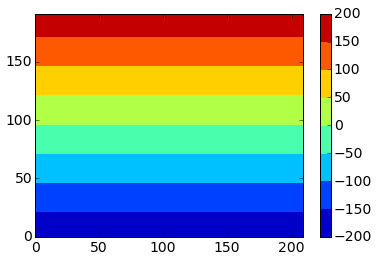

In [207]:
Depth1 = np.zeros_like(Depth)
for xx in range(len(X)):
    for yy in range(len(Y)):
        Depth1[yy,xx] = (xx - len(X)/2)**2 + (yy - len(Y)/2)**2

grad time is: 38.0902400017
roll time is: 20.2059690952


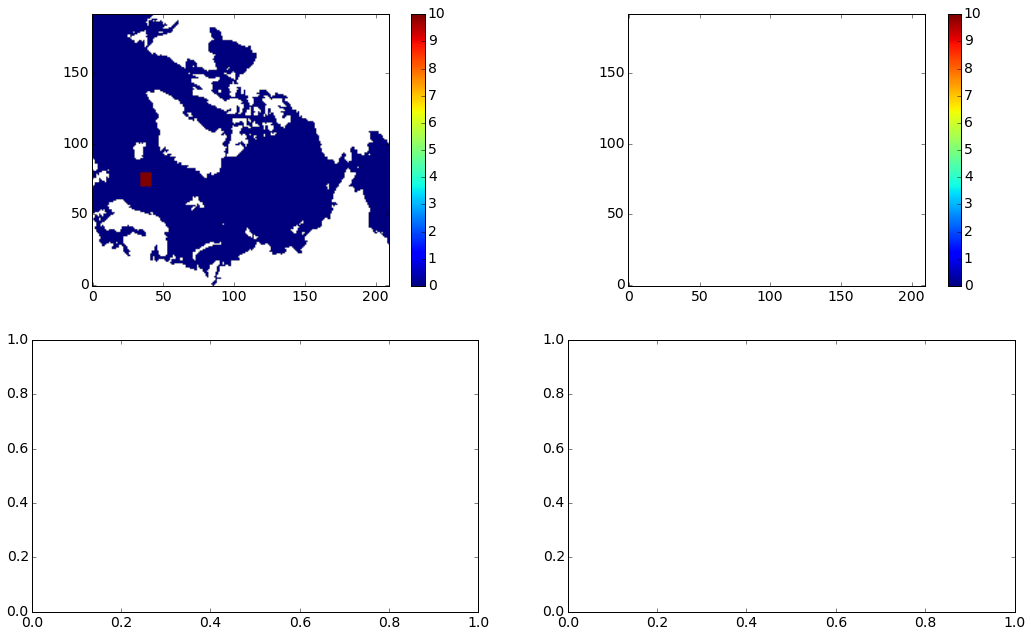

In [237]:
Depth1 = np.zeros_like(Depth)
for xx in range(len(X)):
    for yy in range(len(Y)):
        Depth1[yy,xx] = (xx - len(X)/2)**2 + (yy - len(Y)/2)**2

def plot_vel_grad(S0,Sx,Sy,nt,dt,dx):

    S1 = np.array(S0)   
    Sx2 = np.array(np.gradient(Depth1))[0,:,:]
    Sy2 = np.array(np.gradient(Depth1))[1,:,:]
    
    for i in range(0,nt):
        S1 = S1 + dt*np.array(np.gradient(S1*Sx2))[0,:,:] + dt*np.array(np.gradient(S1*Sy2))[1,:,:]
            
    return S1 

def plot_vel_roll(S0,Sx,Sy,nt,dt,dx):

    S1 = np.array(S0)
    Sx2 = np.array(np.gradient(Depth1))[0,:,:]
    Sy2 = np.array(np.gradient(Depth1))[1,:,:]
    
    for i in range(0,nt):
        S1 = S1 + dt*(np.roll(S1*Sx2, -1, axis=0) - np.roll(S1*Sx2, 1, axis=0)) / (dx*2.) \
                + dt*(np.roll(S1*Sy2, -1, axis=1) - np.roll(S1*Sy2, 1, axis=1)) / (dx*2.)
            

    #S[hfacc[0,:,:]==0]=np.nan
    S00 = np.array(S0)
    #S00[hfacc[0,:,:]==0]=np.nan
    vimin = 0
    vimax = 10
    fig, axes = plt.subplots(2,2)
    S00[hfacc[0,:,:]==0]=np.nan
    a0 = axes[0,0].imshow(S00,vmin=vimin,vmax=vimax,origin="lower")
    cbar = fig.colorbar(a0 , ax=axes[0,0])
    S1[hfacc[0,:,:]==0]=np.nan
    a1 = axes[0,1].imshow(S1,vmin=vimin,vmax=vimax,origin="lower")
    cbar = fig.colorbar(a1 , ax=axes[0,1])
    fig.subplots_adjust(right=2.4,top=2.2)   
    
    return S1 

start = timeit.default_timer()
plot_vel_grad(S0,Sx2,Sy2,nt=20000,dt=0.001,dx=1)
stop = timeit.default_timer()
print "grad time is: "+str(stop - start)

start = timeit.default_timer()
plot_vel_roll(S0,Sx2,Sy2,nt=20000,dt=0.001,dx=1)
stop = timeit.default_timer()
print "roll time is: "+str(stop - start)

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [  0.,   0.,   0., ...,  nan,  nan,  nan],
       [  0.,   0.,   0., ...,  nan,  nan,  nan],
       [  0.,   0.,   0., ...,  nan,  nan,  nan]])

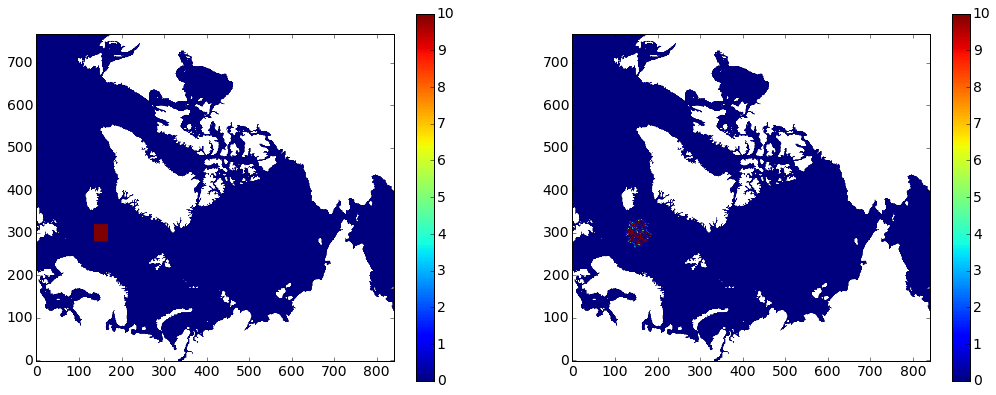

In [312]:
def plot_vel_roll(S0,Sx,Sy,nt,dt,dx):

    S1 = np.array(S0)
    Sx2 = np.array(np.gradient(Depth))[0,:,:]
    Sy2 = np.array(np.gradient(Depth))[1,:,:]
    
    for i in range(0,nt):
        S1 = S1 + dt*(np.roll(S1*Sx2, -1, axis=0) - np.roll(S1*Sx2, 1, axis=0)) / (dx*2.) \
                + dt*(np.roll(S1*Sy2, -1, axis=1) - np.roll(S1*Sy2, 1, axis=1)) / (dx*2.)
            
    S00 = np.array(S0)
    vimin = 0 ; vimax = 10
    fig, axes = plt.subplots(1,2)
    S00[hfacc[0,:,:]==0]=np.nan
    a0 = axes[0].imshow(S00,vmin=vimin,vmax=vimax,origin="lower")
    cbar = fig.colorbar(a0 , ax=axes[0])
    S1[hfacc[0,:,:]==0]=np.nan
    a1 = axes[1].imshow(S1,vmin=vimin,vmax=vimax,origin="lower")
    cbar = fig.colorbar(a1 , ax=axes[1])
    fig.subplots_adjust(right=2.4,top=1.4)   
    return S1 

plot_vel_roll(S0,Sx2,Sy2,nt=10000,dt=0.00001,dx=1)